<a href="https://colab.research.google.com/github/anu-007/make_more_hashtags/blob/main/bigram/makemore_tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prepare data set
import json

tags = []
with open('tags.json', 'r') as file:
  data = json.load(file)
  for d in data:
    tags.append(d[0])

In [2]:
# prepare vocab
chars = sorted(list(set(''.join(tags))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
# create bigram matrix
import torch

N = torch.zeros((51, 51), dtype=torch.int32)
for tag in tags:
    chs = ['.'] + list(tag) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = stoi[ch1]
      ix2 = stoi[ch2]
      N[ix1, ix2] += 1

(np.float64(-0.5), np.float64(50.5), np.float64(50.5), np.float64(-0.5))

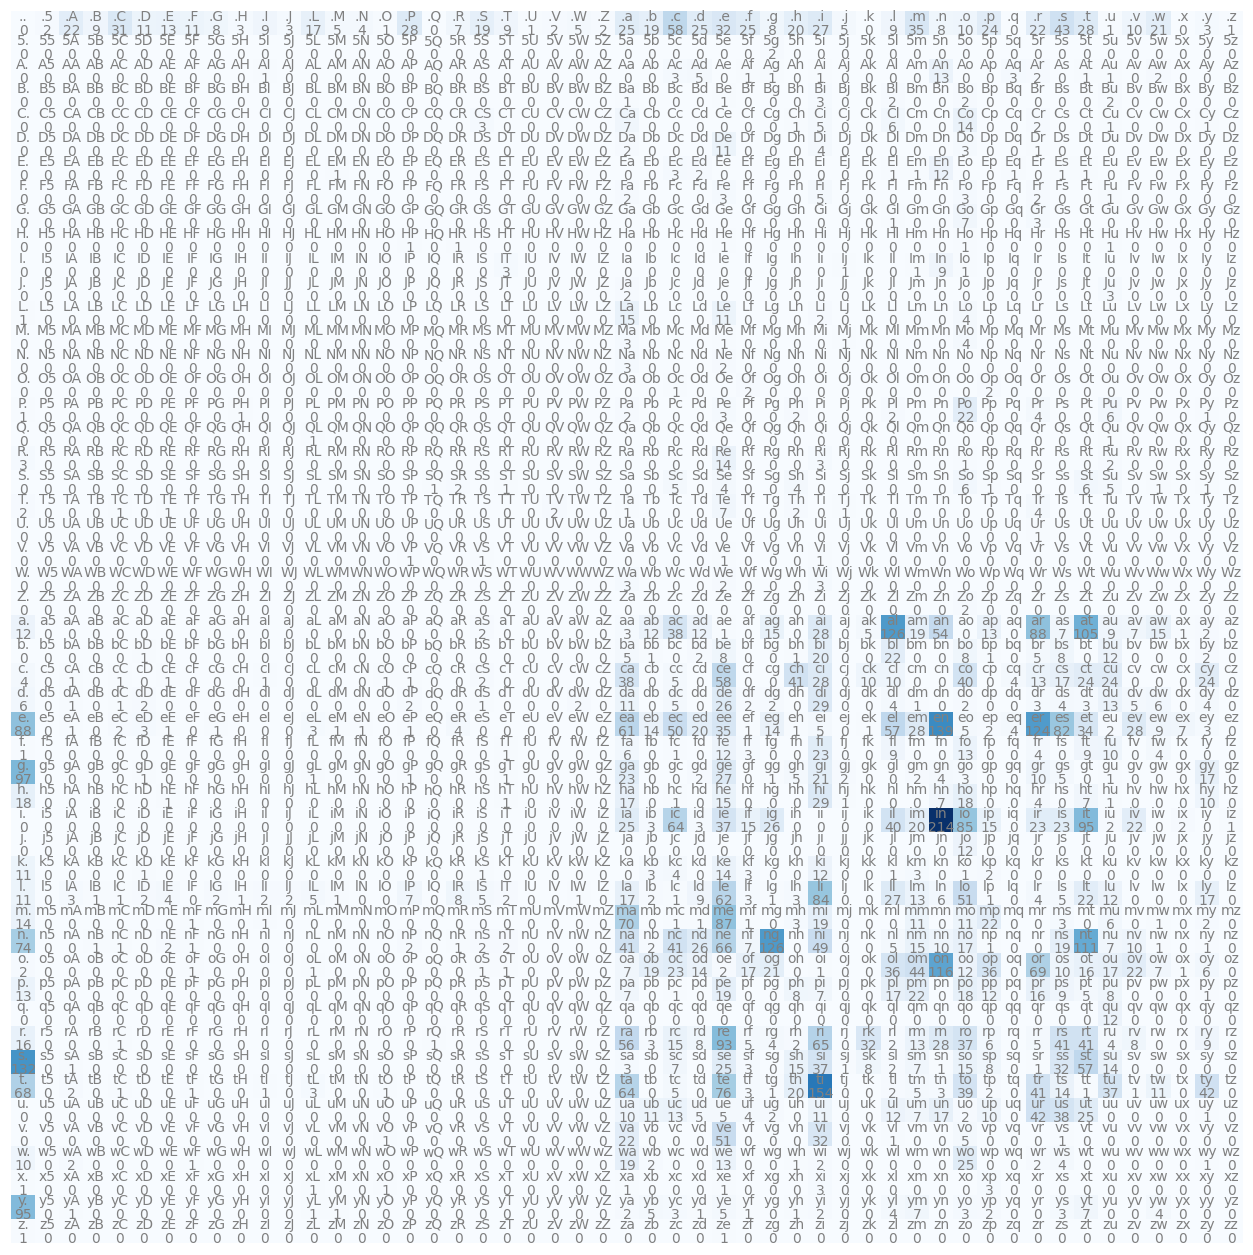

In [ ]:
# plot bigram matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(51):
  for j in range(51):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
    plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [ ]:
# normalize to probabiliy
P = (N + 1).float()
P /= P.sum(1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))

hcititLDengecy.
Cy.
mmelovupmal.
ery.
NZHens.


In [ ]:
# Loss eval
loglkh = 0.0
n = 0
for tag in tags:
  chs = ['.'] + list(tag) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    loglkh += logprob
    n += 1
    # print(f'{ch1}{ch2} : {prob:.4f} : {logprob:.4f}')

print(f'log likelihood {loglkh}')
print(f'avg negative log lkh {-loglkh/n}')

log likelihood -21347.998046875
avg negative log lkh 2.5785720348358154


In [4]:
# neural net implementation
import torch
xs = []
ys = []

for tag in tags[:1]:
  chs = ['.'] + list(tag) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [6]:
# create encoding for the tensors
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((51, 51), generator=g, requires_grad=True)
xenc = F.one_hot(xs, num_classes=51).float()

In [7]:
# add softmax
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([7, 51])

In [ ]:
# sample probabilities
nlls = torch.zeros(7)
for i in range(7):
  x = xs[i].item()
  y = ys[i].item()
  print('--------')
  print(f'input: {itos[x]}')
  print(f'target: {itos[y]}')
  p = probs[i, y]
  logp = torch.log(p)
  print(f'probability: {p:.4f}')
  print(f'log probability: {logp:.4f}')
  nll = -logp
  print(f'negative log likelihood: {nll.item():.4f}')
  nlls[i] = nll

print('--------')
print(f'negative log likelihood: {nlls.mean().item():.4f}')

--------
input: .
target: h
probability: 0.0249
log probability: -3.6934
negative log likelihood: 3.6934
--------
input: h
target: i
probability: 0.0071
log probability: -4.9534
negative log likelihood: 4.9534
--------
input: i
target: r
probability: 0.0022
log probability: -6.1013
negative log likelihood: 6.1013
--------
input: r
target: i
probability: 0.0121
log probability: -4.4115
negative log likelihood: 4.4115
--------
input: i
target: n
probability: 0.0139
log probability: -4.2724
negative log likelihood: 4.2724
--------
input: n
target: g
probability: 0.1002
log probability: -2.3007
negative log likelihood: 2.3007
--------
input: g
target: .
probability: 0.0010
log probability: -6.8672
negative log likelihood: 6.8672
--------
negative log likelihood: 4.6571


In [15]:
# gradient descent for entire data set
xs = []
ys = []
for tag in tags:
  chs = ['.'] + list(tag) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)
W = torch.randn((51, 51), generator=g, requires_grad=True)

number of examples:  8279


In [32]:
for k in range(30):
  # forward pass
  xenc = F.one_hot(xs, num_classes=51).float()
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim=True)

  loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -5.0 * W.grad

2.62066912651062
2.6204607486724854
2.6202526092529297
2.6200449466705322
2.6198384761810303
2.6196322441101074
2.619426727294922
2.6192219257354736
2.6190176010131836
2.618813991546631
2.6186110973358154
2.618408441543579
2.6182069778442383
2.6180059909820557
2.617805242538452
2.617605209350586
2.617405891418457
2.6172072887420654
2.617009162902832
2.616811752319336
2.616614580154419
2.6164186000823975
2.616222858428955
2.61602783203125
2.615833044052124
2.6156392097473145
2.615446090698242
2.615253210067749
2.615061044692993
2.6148693561553955


In [33]:
# sample outputs
for i in range(7):
  out = []
  ix = 0
  while True:
    # before
    # p = P[ix]

    # after
    xenc = F.one_hot(torch.tensor([ix]), num_classes=51).float()
    logits = xenc @ W
    counts = logits.exp()
    p = counts / counts.sum(1, keepdim=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break

  print(''.join(out))


stienalicurssliment.
chaninorertwomalry.
pJWitpmplipqqsintinixuVntimaideltoichps.
ourctingenIwonmeabretudenas.
wouHw.
areechcuil.
Devinelin.
